In [3]:
using PyPlot
using PyCall
using Formatting
using DelimitedFiles
np = pyimport("numpy")
make_axes_locatable = pyimport("mpl_toolkits.axes_grid1").make_axes_locatable

PyObject <function make_axes_locatable at 0x000000006CB971F0>

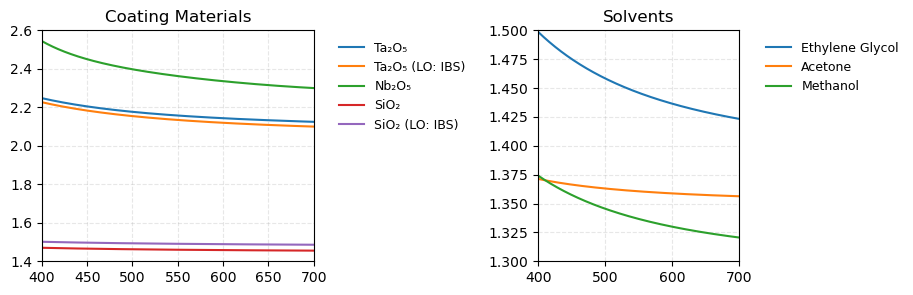

In [4]:
Sellmeier(B, C, λ) = √(1 + sum(Bᵢ*λ^2/(λ^2-Cᵢ) for (Bᵢ, Cᵢ) in zip(B, C)))
# Refractive indices
function n_refr(material, λ::Real)::Float64
    """
    SiO2: https://refractiveindex.info/?shelf=main&book=SiO2&page=Malitson
    Ta2O5: https://refractiveindex.info/?shelf=main&book=Ta2O5&page=Gao
    λ in nm
    """
    λ /= 1000 # nm to μm
    if isa(material, String)
        material = uppercasefirst(material)
    end
    
    if material == "SiO2:IBS" # With IBS, values from Laseroptik
        B = [1.19261271,   0.5415, 0]
        C = [0.0079968567, 61.257, 0]
        return Sellmeier(B, C, λ)
    elseif material == "Ta2O5:IBS" # With IBS, values from Laseroptik
        B = [2.63437,   0.5694, 0.243937]
        C = [0.0355851, 0,      81]
        return Sellmeier(B, C, λ)
    elseif material == "NBK7"
        B = [1.03961212,    0.231792344,  1.01046945]
        C = [0.00600069867, 0.0200179144, 103.560653]
        return Sellmeier(B, C, λ)
    elseif material == "Suprasil" # Heraeus 
        B = [0.473115591, 0.631038719,  0.906404498]
        C = [0.012995717, 0.0041280922, 98.7685322]
        return Sellmeier(B, C, λ)
    elseif material == "SiO2"
        B = [0.6961663, 0.4079426, 0.8974794]
        C = [0.0684043, 0.1162414, 9.8961610]
        return √(1 + sum(B[i]*λ^2/(λ^2-C[i]^2) for i in 1:3)) # Not the Sellmeier formular! --> C[i]²
    elseif material == "Ta2O5" # values empiric from fit (exponential + polynomial) to data
        return 6.70419*exp(-11.1521*λ) + 2.27472 - 0.319763*λ + 0.144455*λ^2
    elseif material == "Nb2O5" # values empiric from fit (exponential + polynomial) to data, only valid between 400...800nm
        return 582.098*exp(-22.1463*λ) + 2.94173+ -1.58087*λ + 0.948068*λ^2
    elseif material in ["EthyleneGlycol", "Ethylenglykol", "EthGly", "EthyGly"]
        return 1.386820 + 17856.021e-6 * λ^(-2)
        # return 1.44
    elseif material in ["Acetone", "Aceton"]
        return 1.34979 + 0.00306λ^-2 + 0.00006λ^-4
    elseif material in ["Methanol"]
        return 1.294611 + 12706.403e-6λ^-2
    elseif material in ["Octadecene"]
        return 1.44        
    elseif material in ["Air", "Vac", "Vacuum"]
        return 1.00
    elseif isa(material, Number) # you can also enter a number like 1.24
        return material
    else
        n = parse(Float64, material)
        if n != nothing
            return n
        else
            ArgumentError("Material not found.")
        end
    end
end

λ = 400:700
plt.figure(figsize=(9, 3))
plt.subplot2grid((1, 10), (0, 0), colspan=4, title="Coating Materials", xlim=extrema(λ), ylim=(1.4, 2.6))
plt.plot(λ, [n_refr("Ta2O5", wlen)     for wlen in λ], label="Ta₂O₅")
plt.plot(λ, [n_refr("Ta2O5:IBS", wlen) for wlen in λ], label="Ta₂O₅ (LO: IBS)")
plt.plot(λ, [n_refr("Nb2O5", wlen)     for wlen in λ], label="Nb₂O₅")
plt.plot(λ, [n_refr("SiO2", wlen)      for wlen in λ], label="SiO₂")
plt.plot(λ, [n_refr("SiO2:IBS", wlen)  for wlen in λ], label="SiO₂ (LO: IBS)")
plt.grid(ls="--", alpha=0.3)
plt.legend(loc=1, fontsize=9, bbox_to_anchor=(1.6, 1), frameon=false);

plt.subplot2grid((1, 10), (0, 7), colspan=3, title="Solvents", xlim=extrema(λ), ylim=(1.3, 1.5))
plt.plot(λ, [n_refr("EthGly", wlen)    for wlen in λ], label="Ethylene Glycol")
plt.plot(λ, [n_refr("Acetone", wlen)   for wlen in λ], label="Acetone")
plt.plot(λ, [n_refr("Methanol", wlen)  for wlen in λ], label="Methanol")
plt.xlim(extrema(λ)...)
plt.grid(ls="--", alpha=0.3)
plt.legend(loc=1, fontsize=9, bbox_to_anchor=(1.85, 1), frameon=false);
# println(n_refr("Nb2O5", 580.0))

In [5]:
function GenerateBraggMirrorStack(λ₀::Real, m_high::Union{Real, String}, m_low::Union{Real, String}; N::Integer, topLayer::Bool)
    """
        create layer stack with individual thickness of λ/4
        returns array of layer thicknesses

        Examples:
        - CRD: N=13, Nb2O5, SiO2
        - LO550: N=19, Ta2O5, SiO2
    """
    n₁, n₂ = n_refr(m_high, λ₀*1e9), n_refr(m_low, λ₀*1e9)
    n = repeat([n₁, n₂], N)

    # add another high n layer on top
    if topLayer == true
        append!(n, n₁)
    end

    d = λ₀ ./ 4n # Thickness: λ/4
    return d
end

function getCustomMirrorStack(;m_high::Union{Real, String}, m_low::Union{Real, String})
    """
        lengths are given in units of λ/4
        reverse order because Laseroptik provides data from substrate side

        returns array of layer thicknesses
    """

    #----- Improved pump transmission
    # λ₀ = 693e-9
    # d = reverse(λ₀ * [0.75741,0.68876,0.8664,0.84454,1.51678,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.00441,0.46688,0.95273,0.59731,1.89814,1.01,1.01,1.01,1.01,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805])

    #----- Smoothing of transmission: Final
    # λ₀ = 570e-9
    # d = reverse(λ₀ * [1.52604662,1.09608991,1.62648768,0.8459486,1.34525973,1.25809304,1.35149071,1.19464964,1.25814221,1.16678573,1.36466614,1.24492899,1.32144582,1.18179031,1.20443081,1.1640676,1.27012323,1.2781804,1.28259679,1.19179742,1.21585772,1.10693806,1.22254394,1.13999445,1.32314508,1.275316,1.32821823,1.24596505,1.31922939,1.32561973,1.3852789,1.50000682,1.23586713,1.07862317,0.83633162,1.04990604,1.07313217,1.00725696,1.02343496,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.71787593,0.20910963])
    
    #----- Zero degree 2021
    λ₀ = 577e-9
    # n₁, n₂ = n_refr(m_high, λ₀*1e9), n_refr(m_low, λ₀*1e9)
    # n = reverse(vcat(repeat([n₁, n₂], 24), n₁))
    d = reverse(λ₀ * [0.93606,0.93021,0.94428188025,0.8793,0.67386,0.21653,0.92916,0.85924,0.88793,0.81784,0.82287,0.82589,0.89287,0.87968,0.93094,0.92011,0.98763,1.37457,1.37032,0.94265,0.96662,0.92173,0.91545,0.88216,0.87477,0.85617,0.91143,0.89408,0.9286,0.92307,1.65457,1.004129603043,0.97952,0.9476,0.96056,0.96055,0.97354,0.94413,0.96186,0.97716,0.9836,1.02031,1.22784,1.23484,1.05889,1.00925,0.99314,2.802,1.062,])
        
    #----- only 570nm part
    # n = reverse(repeat([n₁, n₂], 19))
    # d = reverse(570e-9 .* [1.07313217,1.00725696,1.02343496,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.71787593,0.20910963])
    # n = reverse(repeat([n₁, n₂], 18))
    # d = reverse(570e-9 * [1.52604662,1.09608991,1.62648768,0.8459486,1.34525973,1.25809304,1.35149071,1.19464964,1.25814221,1.16678573,1.36466614,1.24492899,1.32144582,1.18179031,1.20443081,1.1640676,1.27012323,1.2781804,1.28259679,1.19179742,1.21585772,1.10693806,1.22254394,1.13999445,1.32314508,1.275316,1.32821823,1.24596505,1.31922939,1.32561973,1.3852789,1.50000682,1.23586713,1.07862317,0.83633162,1.04990604])

    #----- Trying Stuff out with Nb2O5
    # d = reverse(550e-9 * vcat(repeat([1.35,], 28), repeat([1.0,], 29)))
    
    n₁, n₂ = n_refr(m_high, λ₀*1e9), n_refr(m_low, λ₀*1e9)
    n = repeat([n₁, n₂], length(d) ÷ 2)
    # if no. of layers is uneven, add another one on top
    if isodd(length(d))
        append!(n, n₁)
    end
    n = reverse(n)

    d ./= 4n # λ/4 stacks
    return d
end

# See also: Open-Filters Paper DOI: 10.1364/AO.47.00C219
function TransmissionOfDielectricMirror(λ::Real, θ₀::Real, d::Vector{<:Real}; medium::Union{Real, String}, substrate::Union{Real, String}, m_high::Union{Real, String}, m_low::Union{Real, String})
    """ Transmission of a lossless dielectric mirror with custom layer structure """
    θ₀ = deg2rad(θ₀)
    # n₀: Medium(e.g. Ethyl. Glyc.), ns: Substrate, Material-1, Material-2
    n₀, ns, n₁, n₂ = n_refr(medium, λ*1e9), n_refr(substrate, λ*1e9), n_refr(m_high, λ*1e9), n_refr(m_low, λ*1e9)
    
    n₁, n₂ = n_refr(m_high, λ*1e9), n_refr(m_low, λ*1e9)
    n = repeat([n₁, n₂], length(d) ÷ 2)
    # if no. of layers is uneven, add another one on top
    if isodd(length(d))
        append!(n, n₁)
    end

    if n₀ * sin(θ₀) > ns
        return 0.0, 0.0 # total internal reflection, T = 0
    end
    θ =@. asin(n₀ / n * sin(θ₀)) # propagation angle inside the layers
    θ_out = asin(n₀/ns * sin(θ₀))
        
    k =@. 2π/λ * n
    δ =@. k*d * cos(θ) # phase shift per layer
    # pseudo-indices
    η₀_s, ηs_s, η_s = n₀ * cos(θ₀), ns * cos(θ_out), n .* cos.(θ)
    η₀_p, ηs_p, η_p = n₀ / cos(θ₀), ns / cos(θ_out), n ./ cos.(θ) 
    # Transfer-Matrix-Generators for s- and p-pol. 
    M_s, M_p = ((
        [ cos(δᵢ)         1im*sin(δᵢ)/ηᵢ;
          1im*sin(δᵢ)*ηᵢ  cos(δᵢ)          ] for (δᵢ, ηᵢ) in zip(δ, η)
                                           ) for η in (η_s, η_p)        )
    # Calculation for s- and p-polarization separately
    v₁_s, v₂_s = [η₀_s -1; η₀_s 1] * prod(M_s) * [1, ηs_s]
    R_s = abs2(v₁_s/v₂_s)
    #
    v₁_p, v₂_p = [η₀_p -1; η₀_p 1] * prod(M_p) * [1, ηs_p]
    R_p = abs2(v₁_p/v₂_p)
    
    1 .- R_s, 1 .- R_p
end

TransmissionOfDielectricMirror (generic function with 1 method)

In [6]:
λ_ = 450.0 : 1 : 650.0
λ₀ = 550
θ_ = 0.0 : 1 : 90.0

d = GenerateBraggMirrorStack(λ₀*1e-9, "Nb2O5", "SiO2:IBS"; N=13, topLayer=true)
T_raw = [TransmissionOfDielectricMirror(λ*1e-9, θ, d, medium="EthGly", substrate="SiO2", m_high="Nb2O5", m_low="SiO2:IBS") for θ in θ_, λ in λ_] 
# d = getCustomMirrorStack(m_high="Ta2O5:IBS", m_low="SiO2:IBS")
# T_raw = [TransmissionOfDielectricMirror(λ*1e-9, θ, d, medium="EthGly", substrate="SiO2", m_high="Ta2O5:IBS", m_low="SiO2:IBS") for θ in θ_, λ in λ_]

T_s, T_p = [r[1] for r in T_raw], [r[2] for r in T_raw] # s- and p-polarization
T = (T_s + T_p)/2 # Transmission
size(T_raw), size(T_s)

((91, 201), (91, 201))

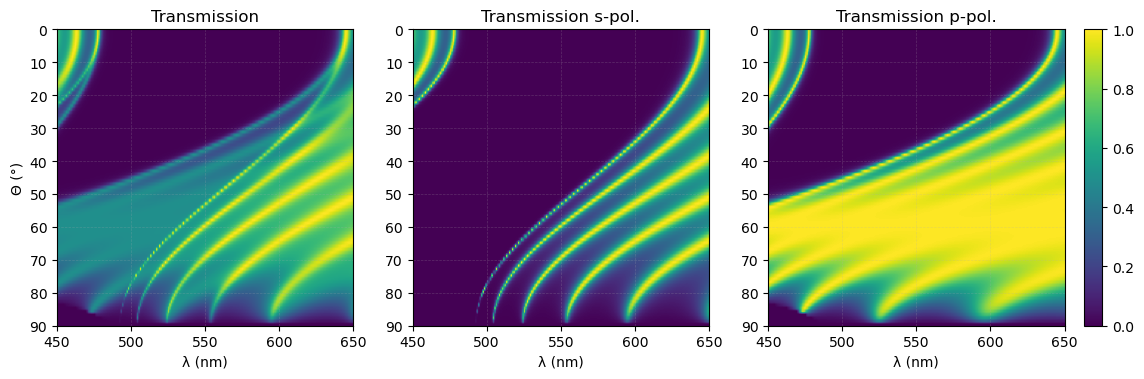

In [7]:
imshow_obj = nothing
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
for (ax, Trans, t) in zip(axs, [T, T_s, T_p], ["Transmission", "Transmission s-pol.", "Transmission p-pol."])
    imshow_obj = ax.imshow(Trans,
        extent = (extrema(λ_)..., reverse(extrema(θ_))...),
        aspect = -(extrema(λ_)...)/-(extrema(θ_)...),
        vmin = 0, vmax = 1, cmap="viridis"
    )
    ax.set(xlabel="λ (nm)", title=t)
    ax.grid(ls="--", alpha=0.25, lw=0.5)
end
axs[1].set_ylabel("Θ (°)")

cax = fig.add_axes([axs[3].get_position().x1+0.015, axs[3].get_position().y0, 0.014, axs[3].get_position().height]) # x, y, width, height
plt.colorbar(imshow_obj, cax=cax);
# plt.savefig("out/CRD550_EthGly.pdf", dpi=300)

In [10]:
angle_idx = argmin(abs.(θ_ .- 35)) # Angle close to...
λ_idx = argmin(abs.(λ_ .- 575)); # which wavelength
scale = "log";

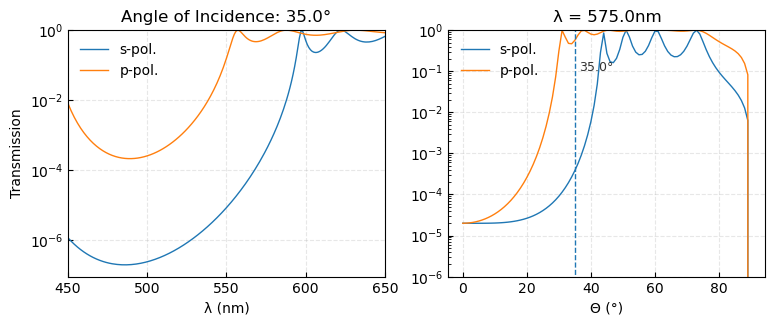

Tₘᵢₙ(θ=35.0°) = 2.01e-07


PyObject <matplotlib.legend.Legend object at 0x000000006DC20E20>

In [11]:
plt.figure(figsize=(9, 3.2))
plt.subplot(121, title=string("Angle of Incidence: $(θ_[angle_idx])°"), xlabel="λ (nm)", ylabel="Transmission")
plt.yscale(ifelse(scale=="log", "log", "linear"))
plt.plot(λ_, T_s[angle_idx, :], lw=1, label="s-pol.")
plt.plot(λ_, T_p[angle_idx, :], lw=1, label="p-pol.")
# plt.plot(wlen_ref, T_ref)
# plt.hlines(5e-6, 400, 700)
# plt.vlines(633, 0, 1, color="k")
plt.grid(ls="--", alpha=0.3);
plt.xlim(extrema(λ_));
plt.ylim(nothing, 1)
plt.legend(frameon=false);
plt.gca().tick_params(which="both", direction="in")
printfmtln("Tₘᵢₙ(θ={}°) = {:.2e}", θ_[angle_idx], minimum(T_s[angle_idx, :]))

plt.subplot(122, title=string("λ = $(λ_[λ_idx])nm"), xlabel="Θ (°)")
plt.yscale(ifelse(scale=="log", "log", "linear"))
plt.plot(θ_, T_s[:, λ_idx], lw=1, label="s-pol.")
plt.plot(θ_, T_p[:, λ_idx], lw=1, label="p-pol.")
plt.grid(ls="--", alpha=0.3)
plt.vlines(θ_[angle_idx], 0, 1, lw=1, ls="--")
plt.text(θ_[angle_idx] + 0.012*abs(-(plt.xlim()...)), 0.1, format("{}°", θ_[angle_idx]), fontsize=9, alpha=0.8)
plt.ylim(1e-6, 1);
plt.gca().tick_params(which="both", direction="in")
plt.legend(frameon=false);
# plt.tight_layout(); plt.savefig("out/HT532.pdf")

In [13]:
# Write values to file
open("out/test.dat", "w") do f
    write(f, "# Materials: Ta2O5 and SiO2\r\n# Zero Degree\r\n# wlen\tT\r\n")
    for (wlen, trans) in zip(λ_, T_s[1, :])
        write(f, format("{:.1f}\t{:.4e}\r\n", wlen, trans))
    end
end
    # write(f, "# Ta2O5 and SiO2. Values are calculated for refractive index of ethylene glycol, n~1.44")
#     for (i, angle) in enumerate(θ_)
#         write(f, format("# Angle of incidence {}°\r\n", angle))
#         write(f, "# wlen\tTs\t\t\t\tTp\r\n")
#         for (wlen, ts, tp) in zip(λ_, T_s[i, :], T_p[i, :])
#             write(f, string(wlen, "\t", format("{:.3e}", ts), "\t", format("{:.3e}", tp), "\r\n"))
#         end
#     end
# end
# np.savetxt("out/Transmission_HT532_in_Air.dat", [λ Tp Ts T], fmt="%.4e", header="λ, T", encoding="utf-8")

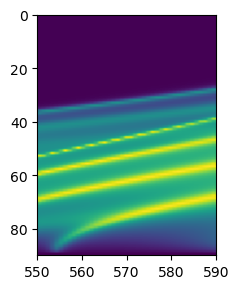

In [36]:
plt.figure(figsize=(5, 3))
plt.imshow(T,
        extent = (extrema(λ_)..., reverse(extrema(θ_))...),
        aspect = 0.6,
        vmin = 0, vmax = 1, cmap="viridis")
#plt.colorbar()
#plt.xlabel("λ (nm)")
#plt.xticks([])
#plt.ylabel("θ (°)")
plt.tight_layout()
#plt.savefig("test.svg")

In [37]:
data = np.loadtxt("res/transmission_losgatos_crd.dat")
wlen_ref, T_ref = data[:, 1], data[:, 2];

### Plot for different angles of incidence

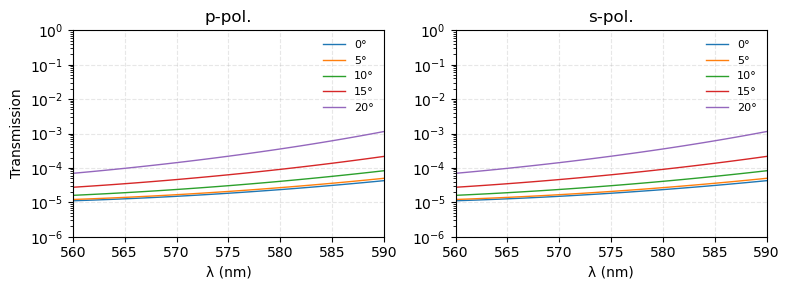

In [38]:
angles = [0, 5, 10, 15, 20]

plt.figure(figsize=(8, 3))
plt.subplot(121, title="p-pol.", xlabel="λ (nm)", ylabel="Transmission", ylim=(1e-6, 1))
plt.yscale("log")
for angle in angles
    plt.plot(λ_, T_p[argmin(abs.(θ_ .- angle)), :], lw=1, label=string(angle, "°"))
end
# plt.plot(wlen_ref, T_ref)
# plt.hlines(5e-6, 400, 700)
# plt.vlines(633, 0, 1, color="k")
plt.grid(ls="--", alpha=0.3);
plt.xlim(560, 590)
plt.legend(frameon=false, fontsize=8)

plt.subplot(122, title="s-pol.", xlabel="λ (nm)", ylim=(1e-6, 1))
plt.yscale("log")
for angle in angles
    plt.plot(λ_, T_p[argmin(abs.(θ_ .- angle)), :], lw=1, label=string(angle, "°"))
end
# plt.plot(wlen_ref, T_ref)
# plt.hlines(5e-6, 400, 700)
# plt.vlines(633, 0, 1, color="k")
plt.grid(ls="--", alpha=0.3);
plt.xlim(560, 590)
plt.legend(frameon=false, fontsize=8)

plt.tight_layout()

### Try to interpolate T(λ, θ)

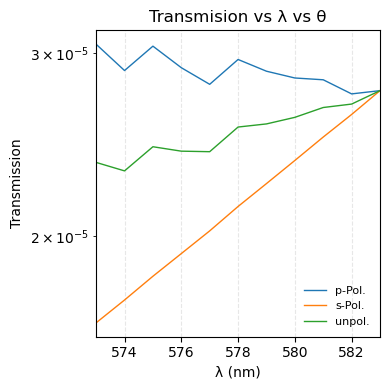

In [39]:
cutoff, specwidth = 583, 10

λ_vs_angle = cutoff .- collect(0:specwidth)
ϵ_vs_angle = 6.626e-34*3e8*(1/λ_vs_angle .- 1/maximum(λ_vs_angle))
alphas =@. √( (cutoff/λ_vs_angle)^2 - 1 ) |> rad2deg # α² = √(λc²/λ² - 1)

Tp_vs_angle = [T_p[argmin(abs.(θ_ .- alpha)), argmin(abs.(λ_ .- wlen))] for (alpha, wlen) in zip(alphas, λ_vs_angle)]
Ts_vs_angle = [T_s[argmin(abs.(θ_ .- alpha)), argmin(abs.(λ_ .- wlen))] for (alpha, wlen) in zip(alphas, λ_vs_angle)]
T_avg_vs_angle = (Tp_vs_angle + Ts_vs_angle)/2

plt.figure(figsize=(4, 4))
plt.subplot(title="Transmision vs λ vs θ", xlabel="λ (nm)", ylabel="Transmission", xlim=(minimum(λ_vs_angle), maximum(λ_vs_angle)), yscale="log")
plt.plot(λ_vs_angle, Tp_vs_angle, "-", lw=1, label="p-Pol.")
plt.plot(λ_vs_angle, Ts_vs_angle, "-", lw=1, label="s-Pol.")
plt.plot(λ_vs_angle, T_avg_vs_angle, "-", lw=1, label="unpol.")

# plt.plot(wlen_ref, T_ref)
# plt.hlines(5e-6, 400, 700)
plt.grid(ls="--", alpha=0.3);
plt.legend(frameon=false, fontsize=8)
plt.tight_layout()

# Write values to file
# np.savetxt("out/Transmission_Laseroptik2019_cutoff$(cutoff)_in_Box.dat", [λ_vs_angle Tp_vs_angle Ts_vs_angle T_avg_vs_angle], fmt="%.4e", header="Only for cutoff $(cutoff) in box potentials\nλ(θ), T_p, T_s, T", encoding="utf-8")

### Some other stuff...

Min: 0.22820186492134908 Max: 0.9999814804831012


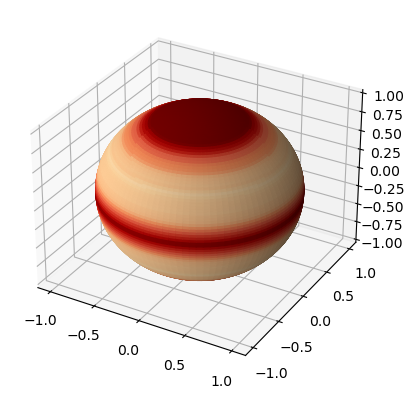

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x0000000095628DF0>

In [45]:
interp1d = pyimport("scipy.interpolate").interp1d
pyimport("mpl_toolkits.mplot3d").Axes3D

surface = interp1d(θ_, losses, kind="cubic", bounds_error=false, fill_value=0)

theta, phi = np.linspace(0, π, 100), np.linspace(0, 2π, 100)
theta, phi = np.meshgrid(theta, phi)
x, y, z =@. sin(theta) * cos(phi), sin(theta) * sin(phi), cos(theta)

fcolors = 1 .- (surface(rad2deg.(theta)) + surface(rad2deg.(π .- theta)))
println("Min: ", minimum(fcolors), " Max: ", maximum(fcolors)); flush(stdout)
fmax, fmin = 1, 0 #maximum(fcolors), minimum(fcolors)
fcolors = (fcolors .- fmin)/(fmax - fmin)

fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=matplotlib.cm.OrRd(fcolors))
#ax.set_axis_off()

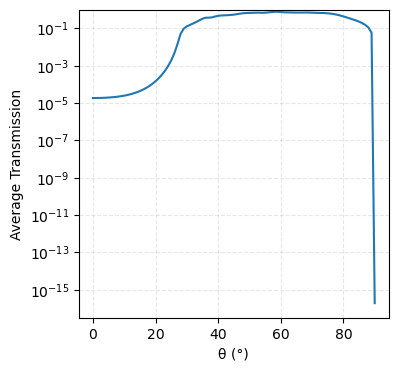

sys:1: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


PyObject Text(23.999999999999993, 0.5, 'Average Transmission')

In [44]:
using Statistics
using PyCall
np = pyimport("numpy")
# Losses(λ, Θ) = ∫ T(λ, Θ) * f(λ)  sin(Θ)dΘ dλ
losses = dropdims(mean(T, dims=2), dims=2)

R6G_ems = np.loadtxt("res/rhodamine6G.abs.ems.dat", usecols=(0, 2))
λ_ref, ems = R6G_ems[:, 1], R6G_ems[:, 2]

plt.figure(figsize=(4, 4))
plt.yscale("log")
plt.plot(θ_, losses) # dims=1: vertical, 2: horizontal, reshape because otherwise it's a 1xN Matrix...
# plt.plot(λ_ref, ems)
plt.ylim(0, 1)
plt.grid(ls="--", alpha=0.3)
plt.xlabel("θ (°)")
plt.ylabel("Average Transmission")